<a href="https://colab.research.google.com/github/JoanWaweru/NLP-Smoking-Project/blob/master/Smoking_Project_~_Joan_Waweru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Smoking-Related Medical QA Agent (CORD-19)

This Colab demo helps you build an intelligent agent that:
- Extracts and visualizes top **smoking-related keywords** from medical abstracts (CORD-19 dataset).
- Indexes abstracts using **semantic embeddings** (via HuggingFace MiniLM).
- Answers user questions via a **chatbot interface**, optionally filtered by keywords.
- Uses **LlamaIndex**, **KeyBERT**, and **Gradio** for backend + frontend functionality.

**Dataset Source:** [CORD-19 metadata CSV](https://github.com/allenai/cord19)

## Installing dependencies

In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes
!pip install gradio llama-index llama-index-llms-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

## Import packages

In [ ]:
import os
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt

from tqdm import tqdm

from llama_index.core import Settings
from llama_index.core import Document
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core import load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

In [ ]:
# Download latest version
path = kagglehub.dataset_download(handle="googleai/dataset-metadata-for-cord19")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dataset-metadata-for-cord19


In [ ]:
os.listdir(path)

['CORD19 datasets - Sheet 1.csv']

In [ ]:
filename_with_path = path + "/" + os.listdir(path)[0]
filename_with_path

'/kaggle/input/dataset-metadata-for-cord19/CORD19 datasets - Sheet 1.csv'

In [ ]:
df_meta_cord19 = pd.read_csv(filename_with_path)
df_meta_cord19.head()

,cord_uid,paper_url,paper_title,dataset_url,dataset_name,alternate_name,description,author_list,last_updated,license,source_organization,doi,compact_identifier,data_download
0,rmzpiyqj,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"Nipah virus: epidemiology, pathology, immunobi...",https://data.csiro.au/dap/landingpage?pid=csir...,Nature of exposure drives transmission of Nipa...,NaN,"[""RT-PCR data of comparative viral loads/ tiss...",Bronwyn Clayton; Deborah Middleton; Rachel Ark...,2016,"[{""url"":""https://confluence.csiro.au/display/d...",CSIRO,10.4225/08/56806AAEAD713,NaN,NaN
1,h7g5ecc0,http://europepmc.org/articles/pmc4052367?pdf=r...,Novel approaches and challenges to treatment o...,https://datamed.org/display-item.php?repositor...,Key Role of T cell Defects in Age-Related Vuln...,NaN,"[""In a mouse model of age-related vulnerabilit...",NaN,2019-05-06,NaN,NaN,NaN,NaN,NaN
2,3uvlmww0,https://jvi.asm.org/content/jvi/88/17/10228.fu...,"Verdinexor, a Novel Selective Inhibitor of Nuc...",https://datamed.org/display-item.php?repositor...,MicroRNA Regulation of Human Protease Genes,NaN,the human protease genes required for influenz...,NaN,2011-10-13,NaN,NaN,NaN,NaN,NaN
3,xzps65et,https://doi.org/10.14745/ccdr.v45i04a01,Climate change and infectious diseases: What c...,https://search.datacite.org/works/10.5065/d6sj...,The NA-CORDEX dataset,NaN,"[""The NA-CORDEX data archive contains output f...",Linda Mearns; Seth McGinnis; Daniel Korytina; ...,2017,"[{""url"":""http://na-cordex.org/terms-use""}]",UCAR/NCAR,10.5065/d6sj1jch,NaN,NaN
4,a6p8te8q,https://jvi.asm.org/content/jvi/79/6/3370.full...,Increased Epitope-Specific CD8(+) T Cells Prev...,http://www.immunedata.org/display-item.php?rep...,CMV CD8 T Cells,NaN,"[""We present human T cell responses in multipl...",NaN,2018-09-17,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_meta_cord19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16070 entries, 0 to 16069
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cord_uid             16070 non-null  object
 1   paper_url            16070 non-null  object
 2   paper_title          16070 non-null  object
 3   dataset_url          16070 non-null  object
 4   dataset_name         16070 non-null  object
 5   alternate_name       132 non-null    object
 6   description          14126 non-null  object
 7   author_list          6052 non-null   object
 8   last_updated         12548 non-null  object
 9   license              12788 non-null  object
 10  source_organization  12518 non-null  object
 11  doi                  5923 non-null   object
 12  compact_identifier   2080 non-null   object
 13  data_download        5500 non-null   object
dtypes: object(14)
memory usage: 1.7+ MB


In [ ]:
df_filtered = df_meta_cord19[df_meta_cord19['description'].notnull()]
df_description_only = df_filtered[['description']]
#calculate words that are in the abstract, row by row, in the abstract column
df_description_only['word_count'] = df_description_only['description'].apply(lambda x: len(str(x).split()))

<ipython-input-8-416706d61496>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_description_only['word_count'] = df_description_only['description'].apply(lambda x: len(str(x).split()))


# Extract & Plot Smoking-Related Keywords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Focus only on smoking-related abstracts
smoking_keywords = ['smoking', 'smoke', 'tobacco', 'nicotine', 'cigarette', 'vaping', 'e-cigarette', 'secondhand', 'lung cancer']

In [ ]:
# Function to match any smoking-related term in the abstract
def contains_smoking_terms(text):
    return any(kw in text.lower() for kw in smoking_keywords)

In [ ]:
# Apply the filter
smoking_only_df = df_description_only[df_description_only['description'].apply(contains_smoking_terms)]

# Debug: Check how many descriptions were retained
print(f"Number of smoking-related abstracts: {len(smoking_only_df)}")
print(smoking_only_df["description"].head(3))

Number of smoking-related abstracts: 75
336    Background\nEarly detection of lung cancer is ...
471    INTERACTS WITH (S)-nicotine (ortholog); DDT (o...
598    The use of hospital isolation rooms has increa...
Name: description, dtype: object


## Validation & Visualizations

In [ ]:
# Set consistent plotting style
sns.set(style="whitegrid")

In [ ]:
train, temp = train_test_split(smoking_only_df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)
print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 52, Validation: 11, Test: 12


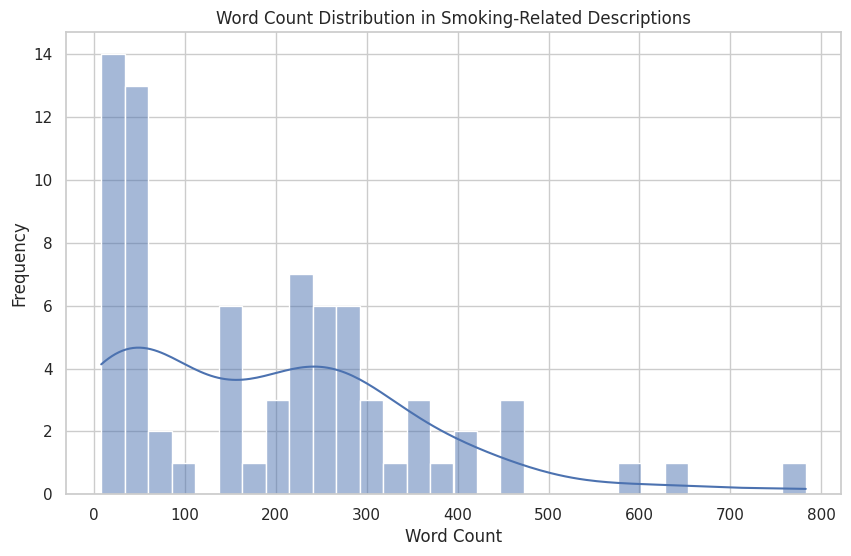

In [ ]:
# Visualization 1: Word Count
plt.figure(figsize=(10,6))
sns.histplot(smoking_only_df['word_count'], bins=30, kde=True)
plt.title("Word Count Distribution in Smoking-Related Descriptions")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

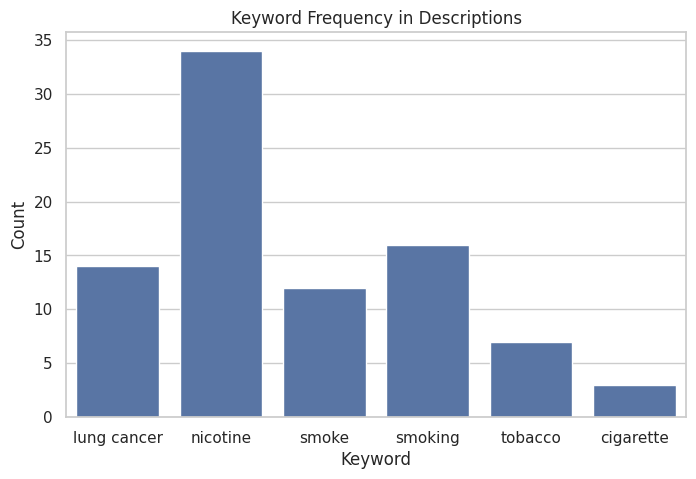

In [ ]:
# Visualization 2: Keyword Frequency
keyword_counts = Counter()
for desc in smoking_only_df['description']:
    for kw in smoking_keywords:
        if kw in desc.lower():
            keyword_counts[kw] += 1

plt.figure(figsize=(8,5))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
plt.title("Keyword Frequency in Descriptions")
plt.ylabel("Count")
plt.xlabel("Keyword")
plt.show()

## Create a vector database using the LlamaIndex function library.

In [ ]:
model_name = "pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb"

Settings.llm = None
Settings.embed_model = HuggingFaceEmbedding(model_name=model_name, device="cuda")

LLM is explicitly disabled. Using MockLLM.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
chunks = []
chunk_size_by_words = 150

for text in tqdm(df_description_only["description"].values):
    text_split = text.split(" ")
    for i in range(0, len(text_split), chunk_size_by_words):
        chunk = " ".join(text_split[i:i + chunk_size_by_words])
        chunks.append(Document(text=chunk))

print(f"Total chunks created: {len(chunks)}")

100%|██████████| 14126/14126 [00:00<00:00, 31317.92it/s]

Total chunks created: 20422


In [ ]:
index = VectorStoreIndex.from_documents(chunks, show_progress=True, insert_batch_size=len(chunks))
index.storage_context.persist(persist_dir="storage")

Parsing nodes:   0%|          | 0/20422 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/20422 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
persist_dir="storage"

In [ ]:
loaded_storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
index = load_index_from_storage(loaded_storage_context)
print(f"VectorStoreIndex loaded from {persist_dir}.")

VectorStoreIndex loaded from storage.


In [ ]:
query_text = "What are the effects of smoking."
query_engine = index.as_query_engine(similarity_top_k=10)

response = query_engine.query(query_text)

# Print the results
print(f"Query: {query_text}\n")
print("Source details:")
for node in response.source_nodes:
  text = node.text.replace('\n', " ")
  print(f"Node ID: {node.node_id}\nScore: {node.score}\n{text[:200]}\n")

Query: What are the effects of smoking.

Source details:
Node ID: ac4581ff-4ad2-4de0-96eb-99ea42fa899b
Score: 0.5734394886341362
["Background\nTobacco dependence is the leading cause of preventable death and disabilities worldwide and nicotine is the main substance responsible for the addiction to tobacco. A vaccine against nic

Node ID: e56ba029-f0b9-4062-b6f5-22b0fe6a231e
Score: 0.5034421726708413
["Rationale\nEmphysema and osteoporosis are epidemiologically associated diseases of cigarette smokers. The causal mechanism(s) linking these illnesses is unknown. We hypothesized autoimmune responses

Node ID: e081b99b-35ad-4573-994e-e2c3d9b39118
Score: 0.48033694311309
["INTERACTS WITH (S)-nicotine (ortholog); DDT (ortholog); formaldehyde (ortholog)"]

Node ID: 82ac7edb-b50d-4b0a-b6ef-00f8e6bbb381
Score: 0.4681525121507662
INTERACTS WITH (S)-nicotine (ortholog); DDT (ortholog); formaldehyde (ortholog)

Node ID: 5b964dd5-ea3d-406f-821f-4ba61745018c
Score: 0.45467474902170546
["Pulmonary ac

## Create Agent

In [ ]:
# Create the language model (LLM) that the agent will use.

from llama_index.llms.huggingface import HuggingFaceLLM

llm = HuggingFaceLLM(
    model_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",       # Language model setup
    tokenizer_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",   # Setting up a language model tokenizer
    context_window=2048,                                          # Maximum token limit
    max_new_tokens=256,                                           # Maximum response length
    device_map="cuda:0",                                          # GPU usage,
    generate_kwargs={"temperature": 0.95, "do_sample": True},     # These parameters affect the randomness and creativity of the model's responses.
)

adapter_config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
Settings.llm = llm

In [ ]:
# We create the chat engine, which is responsible for the agent's dialogue.
You maintain a conversational and helpful tone while ensuring all information is medically sound and fact-based.

from llama_index.core.memory import ChatMemoryBuffer

chat_engine = index.as_chat_engine(
    # This parameter sets whether the chat engine uses the previously created vector database for responses.
    chat_mode="context",
    # This parameter sets the chat engine memory. ChatMemoryBuffer remembers previous conversations.
    memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
    # This parameter sets the system message that affects the agent's behavior. In this case, the agent is a medical chatbot that responds based on the MedQuad dataset.
    system_prompt=(
    "You are a medical chatbot specialized in answering questions about Smoking and related topics such as nicotine, vaping, second-hand smoke, lung cancer, COVID-19, addiction, and other respiratory health concerns. "
    "You provide informative and safe responses based only on the MedQuad dataset. "
    "You maintain a conversational and helpful tone while ensuring all information is medically sound and fact-based."
)

)

In [ ]:
import gradio as gr
from llama_index.core import StorageContext, load_index_from_storage, Settings
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.llms.huggingface import HuggingFaceLLM


# Define the chatbot function
def chatbot(user_input, history=[]):
    result = chat_engine.chat(user_input)
    response = result.response
    history.append((user_input, response))
    return history, history

# Create a Gradio chat interface
with gr.Blocks() as demo:
    gr.Markdown("# 🧠 MedQuad Medical Chatbot")
    chatbot_ui = gr.Chatbot()
    msg = gr.Textbox(label="Ask about smoking-related medical questions", placeholder="e.g., What are the effects of smoking on the lungs?")
    clear_btn = gr.Button("Clear Chat")

    state = gr.State([])

    msg.submit(chatbot, [msg, state], [chatbot_ui, state])
    clear_btn.click(lambda: ([], []), inputs=[], outputs=[chatbot_ui, state])

# Launch the app
if __name__ == "__main__":
    demo.launch()


<ipython-input-30-d9e7b1cad4f2>:17: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_ui = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://77e5eafc5c81a7c453.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
